## Steel Defect Detection

In this notebook I will focus on implementing a ResUNet architecture to predict the location and type of defects found on a steel surface during manufacturing

Data-set : https://www.kaggle.com/c/severstal-steel-defect-detection

#### Model Architecture:

1. Binary Classification Pipeline to predict defect or no defect in a given image 
2. Segmentation model to detect the type and localise the defects.

## Import Packages

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
import cv2
import tensorflow as tf



### Simple EDA 

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("sample_submission.csv")

train_df.shape

(7095, 3)

In [3]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
defect_type =  train_df.ClassId.value_counts()
defect_type

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [5]:
# Add a new column for the defect 
train_df['Defect'] = train_df['ClassId'].apply(lambda x:1)
defect = train_df.groupby(['ImageId'])['Defect'].sum()
defects = defect.value_counts()
defects

1    6239
2     425
3       2
Name: Defect, dtype: int64

Images with atleast one defect: 6666
Total number of defects: 7095


Text(0, 0.5, 'Number of images')

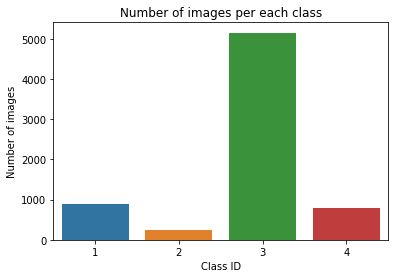

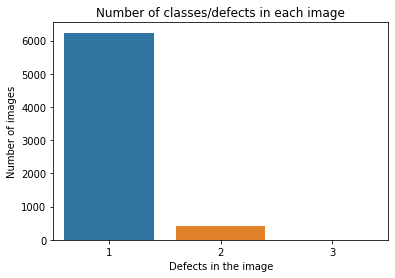

In [6]:
print('Images with atleast one defect: %s' % sum(defects))
print('Total number of defects: %s' % len(train_df['Defect']))

# Plot the Defects wrt to each image and vice versa

fig, ax = plt.subplots()
sns.barplot(x=defect_type.index, y=defect_type, ax=ax)
ax.set_title("Number of images per each class");
ax.set_xlabel("Class ID")
ax.set_ylabel("Number of images")

fig, ax = plt.subplots()
sns.barplot(x=defects.index, y=defects, ax=ax)
ax.set_title("Number of classes/defects in each image")
ax.set_xlabel("Defects in the image")
ax.set_ylabel("Number of images")



In [7]:
train_dir = 'Dataset/train_images'
no_defect = []
for i in os.listdir(train_dir):
    if i not in list(train_df.ImageId):
        no_defect.append(i)

print('Total number of images in training directory: %s' % len(os.listdir(train_dir)))
print('Total number of images with no defect: %s' % len(no_defect))

Total number of images in training directory: 12568
Total number of images with no defect: 5902


#### Dataframe Creation containing both the defect and non defect steel images

In [8]:
Image_id = [i for i in train_df.ImageId]

for i in no_defect:
    Image_id.append(i)
    
# Creating labels label '0' - no defect & '1' - defect
label = [1 for i in train_df.ImageId]
for i in no_defect:
    label.append(0)

df = pd.DataFrame({'ImageID': Image_id, 'label': label})
df.head()

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


In [9]:
print(df.shape)
Defects = df.label.value_counts()
print(Defects)

(12997, 2)
1    7095
0    5902
Name: label, dtype: int64


Text(0, 0.5, 'Number of images')

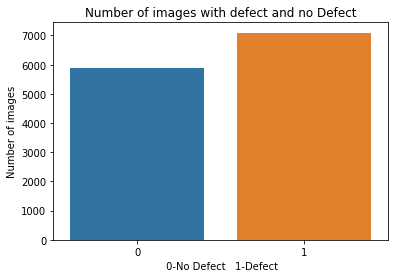

In [10]:
fig, ax = plt.subplots()
sns.barplot(x=Defects.index, y=Defects, ax=ax)
ax.set_title("Number of images with defect and no Defect")
ax.set_xlabel(" 0-No Defect   1-Defect")
ax.set_ylabel("Number of images")

### RLE Functions - Run Length Encode  & Decode  
Function to convert Encoded Pixels into mask  

Thanks to https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [11]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Test RLE functions
assert mask2rle(rle2mask(train_df['EncodedPixels'].iloc[0]))==train_df['EncodedPixels'].iloc[0]
assert mask2rle(rle2mask('1 1'))=='1 1'

### Visualizing the mask

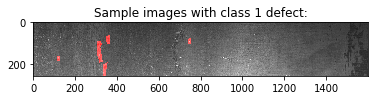

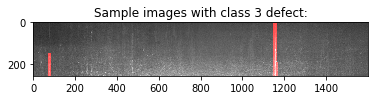

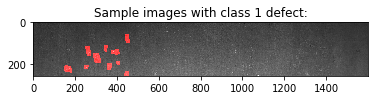

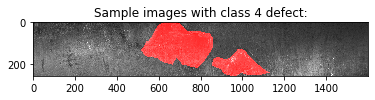

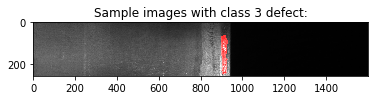

In [12]:
for i in range(5):
    img = cv2.imread(os.path.join(train_dir,train_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(train_df.EncodedPixels[i])
    img[mask == 1,0] = 255
    plt.figure()
    plt.title('Sample images with class {} defect:'.format(train_df.ClassId[i]))
    plt.imshow(img)